# Project 1 : Inverted Pendulum

### Shanmukha Chaitanya Peddeti       ASU id: 1228632836

# Documentation:

<img src="/1.jpg" width="" align="" />

<img src="/2.jpg" width="" align="" />

<img src="/3.jpg" width="" align="" />

<img src="/4.jpg" width="" align="" />

In [1]:
# overhead
import logging
import math
import random
import numpy as np
import time
import torch 
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

!pip install ipywidgets
from ipywidgets import IntProgress
from IPython.display import display
from matplotlib import pyplot as plt, rc
from matplotlib.animation import FuncAnimation, PillowWriter
rc('animation', html='jshtml')
!pip install jupyterthemes
from jupyterthemes import jtplot
jtplot.style(theme='grade3', context='notebook', ticks=True, grid=False)

logger = logging.getLogger(__name__)



[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# Parameter
BOOST_ACCEL = 65 # thrust constant
FRAME_TIME = 0.01  # time interval
m = 1 # mass of the pendulum
M = 5 # mass of the cart
l = 0.6 # lenth of the pendulum
g = 9.81 # accleration due to gravity


In [3]:
class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    def forward(self, state, action):
        """
        action[0] = Thrust
        
        state[0] = x       Displacement of the cart
        state[1] = vx      Velocity of the cart
        state[2] = theta   Angle of the pendulum w.r.t vertical
        state[3] = vtheta  Angular velocity of the pendulum
      
        """ 
        s = torch.sin(state[0,2])
        c = torch.cos(state[0,2])
        deno = M + m*(s**2)

        # delta1 is second order PDE due to effect of dynamics
        delta1 = m*l*(state[0,3]**2)*(1/deno)*torch.tensor([[0., s, 0., -s*c*(1/l)]]) 
        
        # delta1 is second order PDE due to effect of gravity
        delta2 = g*(1/deno) * torch.tensor([0., m*s*c, 0., -(m+M)*s*(1/l)]) 
        
        # delta1 is second order PDE due to effect of action
        # delta3 = (torch.mul(torch.tensor([[0., 1, 0., -s*(1/l)]]), action[0, 0].reshape(-1, 1)))/deno
        delta3 = BOOST_ACCEL *(torch.mul(torch.tensor([[0., 1, 0., -s*(1/l)]]), action[0, 0].reshape(-1, 1)))/deno
        
        step_mat = torch.tensor([[1., FRAME_TIME, 0., 0.],
                                 [0., 1., 0., 0.],
                                 [0., 0., 1., FRAME_TIME],
                                 [0., 0., 0., 1.],])

        state = (step_mat @ state.T) + FRAME_TIME*(delta1.T + delta2.T + delta3.T) 
        state = state.T
        
        return state


In [4]:
class Controller(nn.Module):
    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states = 4
        dim_output: # of actions = 1
        dim_hidden: 
        """
        super(Controller, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            nn.Sigmoid())

    def forward(self, state):
        action = self.network(state)
        action = (action - torch.tensor([0.])) # controlling accleration of cart
        return action
     

In [5]:
class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.theta_trajectory = torch.empty((1, 0))
        self.u_trajectory = torch.empty((1, 0))

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller(state)
            state = self.dynamics(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [[0.,0.5,-1.,0.]] # initial positions
        return torch.tensor(state, requires_grad=False).float()

    def error(self, state):

        # if (state[0,2] %(2*np.pi)) >= 6.26573 or (state[0,2] %(2*np.pi)) <= 0.0174533 :
        #     return 0
            
        # The error is a minimizing function of Velocit of the cart,Angle and Angular velocity of the pendulum 
        return  ((state[0,1]**2) +(state[0,2]**2) +(state[0,3]**2) / 3)
        

In [6]:
class Optimize:
    
    # create properties of the class (simulation, parameters, optimizer, lost_list). Where to receive input of objects
    
    def __init__(self, simulation):
        self.simulation = simulation # define the objective function
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01) # define the opmization algorithm
        self.loss_list = []

    # Define loss calculation method for objective function
    
    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)  # calculate the loss of objective function
            self.optimizer.zero_grad()
            loss.backward() # calculate the gradient
            return loss

        self.optimizer.step(closure)
        return closure()

    # Define training method for the model
    

    def train(self, epochs):
        # self.optimizer = epoch
        l = np.zeros(epochs)
        for epoch in range(epochs):
            self.epoch = epoch
            loss = self.step() # use step function to train the model
            self.loss_list.append(loss) # add loss to the loss_list
            print('[%d] loss: %.3f' % (epoch + 1, loss))

            l[epoch]=loss
            self.visualize()
            
        plt.plot(list(range(epochs)), l)
            
        plt.title('Objective Function Convergence Curve')
        plt.xlabel('Training Iteration')
        plt.ylabel('Error')
        plt.show()
        self.animation(epochs)
        
    # Define result visualization method

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        vx = data[:, 1]
        theta = data[:, 2]%(2*torch.pi)
        vtheta = data[:, 3]
        action_data = np.array([self.simulation.action_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        force = action_data[:,0]
        frame = range(self.simulation.T)

        fig, ax = plt.subplots(2, 3, tight_layout = 1, figsize = (20, 10))

        ax[0,0].plot(frame, x, c = 'b', label = "X")
        ax[0,0].set_xlabel("Time Interval")
        ax[0,0].set_ylabel("x (m)")
        ax[0,0].set(title=f'Displacement of the cart at frame {self.epoch}')

        ax[0,1].plot(frame, vx, c = 'c', label = "Vx")
        ax[0,1].set_xlabel("Time Interval")
        ax[0,1].set_ylabel("Vx (m/s)")
        ax[0,1].legend(frameon=0)
        ax[0,1].set(title =f'Velocity of the cart at frame {self.epoch}')

        ax[1,0].plot(frame, theta, c = 'g', label = "Theta")
        ax[1,0].set_xlabel("Time Interval")
        ax[1,0].set_ylabel("Theta (rad)")
        ax[1,0].legend(frameon=0)
        ax[1,0].set(title=f'Angle of the pendulum at {self.epoch}')

        ax[1,1].plot(frame, vtheta, c = 'g', label = "V_theta")
        ax[1,1].set_xlabel("Time Interval")
        ax[1,1].set_ylabel("Angular velocity (rad/s)")
        ax[1,1].legend(frameon=0)
        ax[1,1].set(title=f'Angular velocity of the pendulum at {self.epoch}')

        ax[1,2].plot(frame, force, c = 'y', label = "Force")
        ax[1,2].set_xlabel("Time Interval")
        ax[1,2].set_ylabel("Force (N)")
        ax[1,2].legend(frameon=0)
        ax[1,2].set(title=f'Force on the cart at {self.epoch}')

        plt.show()

        # print('Displacement:', x)
        # print('Velocity:', vx)
        for i in range(len(theta)):
            print('Angle:', math.degrees(theta[i]) ,theta[i])
        # print('Angular Velocity:', vtheta)
        # print('Force:', force)

    def animation(self, epochs):

        v_exhaust = 1     
        print("Generating Animation")
        steps = self.simulation.T + 1
        final_time_step = round(1/steps,2)
        f = IntProgress(min = 0, max = steps)
        display(f)

        data = np.array([self.simulation.state_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        action_data = np.array([self.simulation.action_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])

        x_t = data
        u_t = action_data
        print(x_t.shape, u_t.shape)

        fig = plt.figure(figsize = (5,10), constrained_layout=False)
        ax1 = fig.add_subplot(111)
        plt.axhline(y=-0.5, color='black', linestyle='--', lw=1)

        rod_fig, = ax1.plot([], [], linewidth = 4.5, color = 'black') # pendulum rod 
        pend_fig,= ax1.plot([], [], 'o', color = 'red', markersize = 12) # pendulum mass
        cart_fig,= ax1.plot([], [], 's', color = 'skyblue', markersize=20) # cart body
        force_fig,= ax1.plot([], [], linewidth = 6.5, color = 'green') # force line


        plt.tight_layout()

        ax1.set_xlim(-1,5 )
        ax1.set_ylim(-2, 3)
        ax1.set_aspect(1)  # aspect of the axis scaling, i.e. the ratio of y-unit to x-unit

        def update(i):

            x_1 = x_t[i,0]
            vx_1 = x_t[i,1]
            theta = x_t[i,2]
            vtheta_1 = x_t[i,3]

            cart_x = x_1 #+ vx_1 * FRAME_TIME
            pendulum_x =  cart_x + (l * math.sin(theta))
            pendulum_y = l * math.cos(theta)
        
            rod_fig.set_data([cart_x, pendulum_x], [0, pendulum_y])
            pend_fig.set_data(pendulum_x, pendulum_y)
            cart_fig.set_data(cart_x,0)

            force_1 = u_t[:i, 0]
            force_fig.set_data(cart_x+force_1 -0.5,0)

            f.value += 1

        playback_speed = 5000 # the higher the slower 
        anim = FuncAnimation(fig, update, np.arange(0, steps-1, 1), interval= final_time_step * playback_speed)

        # Save as GIF
        writer = PillowWriter(fps=20)
        anim.save("inverted pendulum_.gif", writer=writer)
        

[1] loss: 16.006


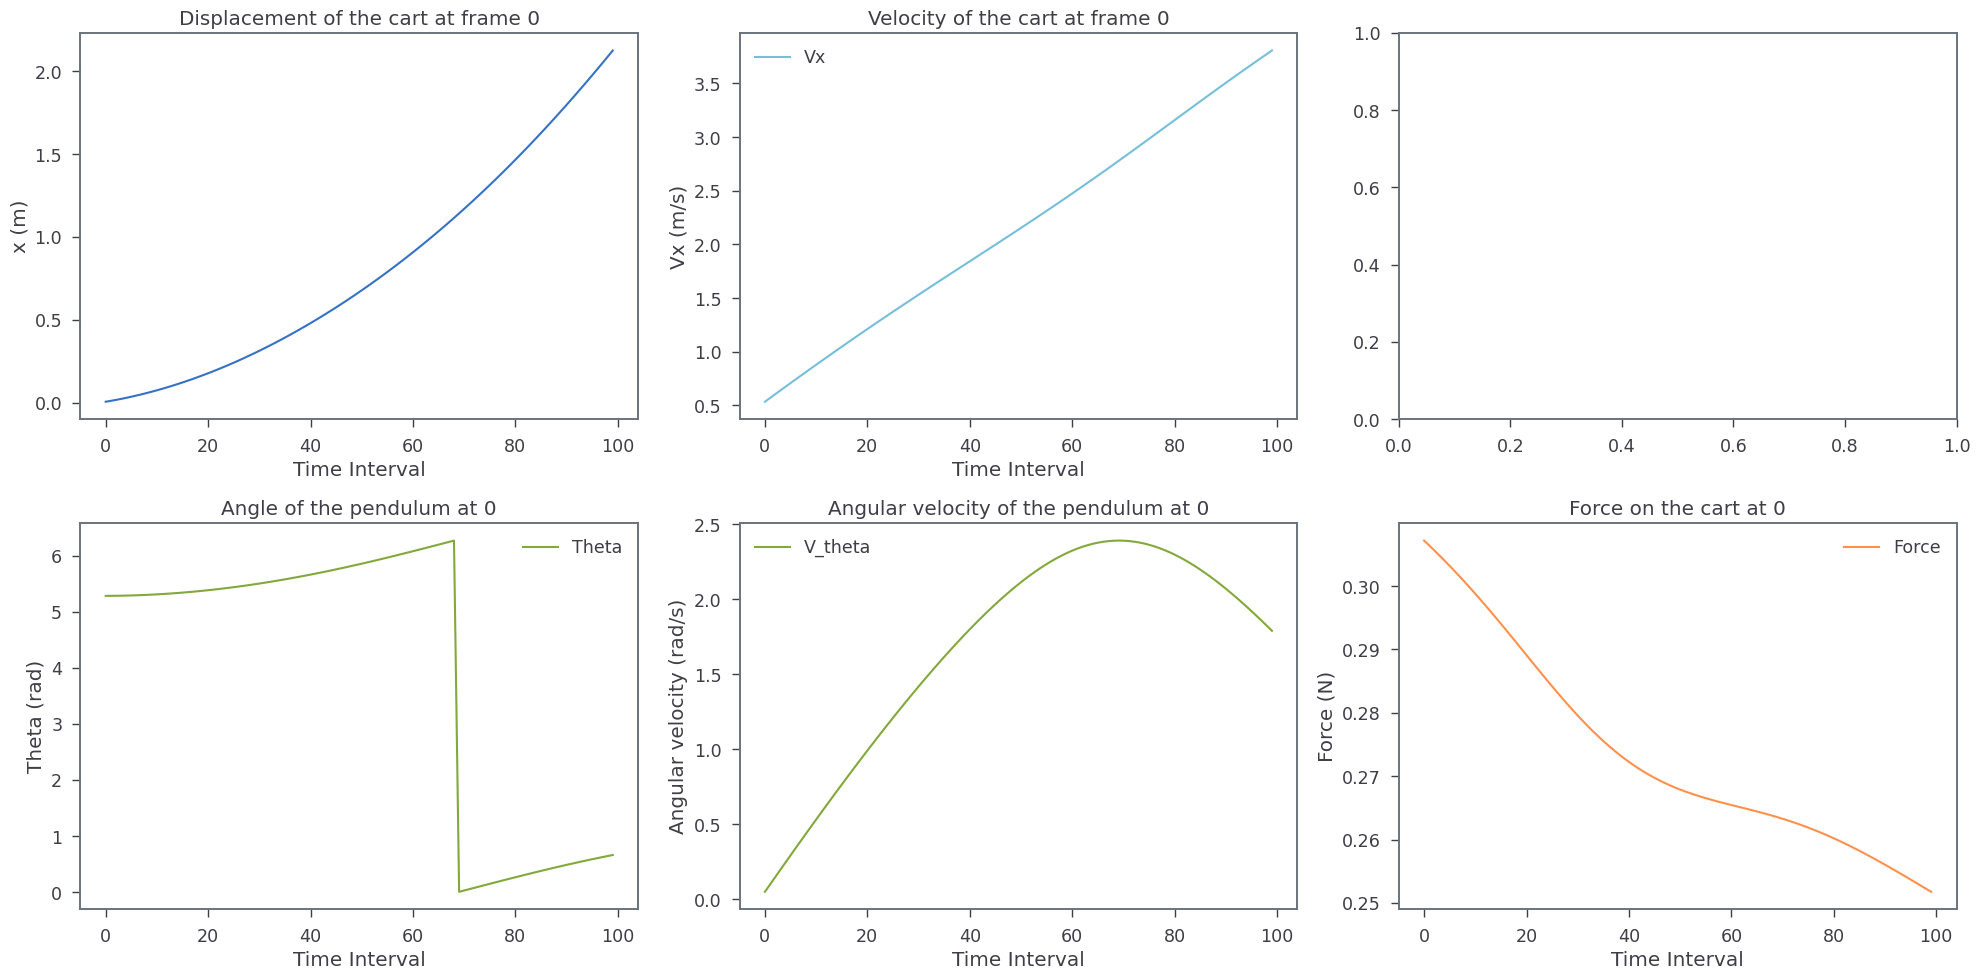

Angle: 302.7042305048303 5.2831855
Angle: 302.7323435634541 5.283676
Angle: 302.7884877184316 5.284656
Angle: 302.8726083282495 5.286124
Angle: 302.984596109881 5.288079
Angle: 303.12439642181283 5.2905188
Angle: 303.29187266026156 5.293442
Angle: 303.4869701837138 5.296847
Angle: 303.7095797091429 5.300732
Angle: 303.9595646327653 5.305095
Angle: 304.2368156715545 5.309934
Angle: 304.5412508632403 5.3152475
Angle: 304.872678962526 5.321032
Angle: 305.23101800714153 5.3272862
Angle: 305.61613139330353 5.3340077
Angle: 306.0278278757152 5.341193
Angle: 306.4659981713499 5.3488407
Angle: 306.93045103491073 5.356947
Angle: 307.42104986261444 5.3655095
Angle: 307.93763072992084 5.3745255
Angle: 308.4800023915332 5.3839917
Angle: 309.0479736021548 5.3939047
Angle: 309.6413804372455 5.4042616
Angle: 310.26005897226526 5.4150596
Angle: 310.90373599964727 5.426294
Angle: 311.5722749156081 5.437962
Angle: 312.265402512581 5.4500594
Angle: 312.98295486602586 5.462583
Angle: 313.72468608913255 5.

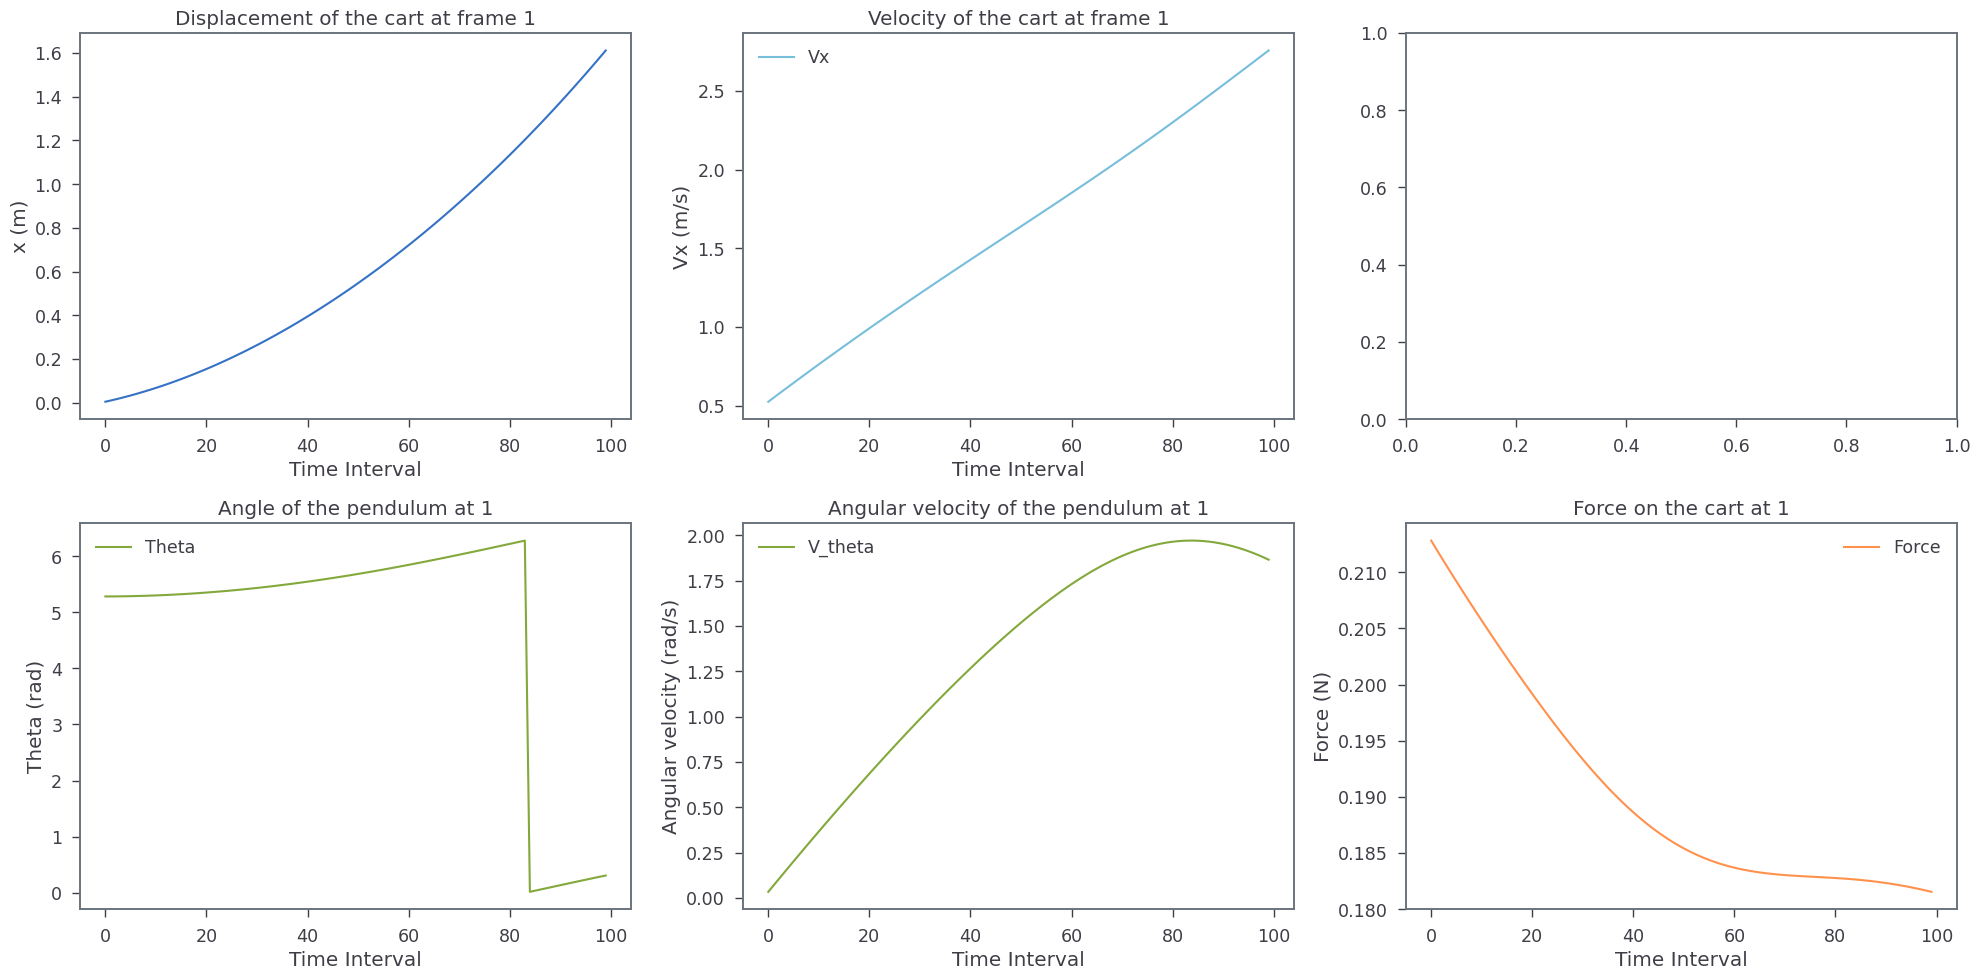

Angle: 302.7042305048303 5.2831855
Angle: 302.7237102043432 5.2835255
Angle: 302.76258764109895 5.284204
Angle: 302.8208081735841 5.28522
Angle: 302.89828983952873 5.2865725
Angle: 302.9949779974194 5.28826
Angle: 303.11079068498617 5.2902813
Angle: 303.24564593995893 5.292635
Angle: 303.3994618000676 5.2953196
Angle: 303.5721836237989 5.298334
Angle: 303.76370212812606 5.3016768
Angle: 303.9739899922924 5.305347
Angle: 304.20291061251453 5.3093424
Angle: 304.4504093472791 5.313662
Angle: 304.71637691355943 5.318304
Angle: 305.0007313490854 5.323267
Angle: 305.3034180123437 5.32855
Angle: 305.62432762030755 5.334151
Angle: 305.96335088995033 5.340068
Angle: 306.3204058590019 5.3462996
Angle: 306.6953832444356 5.352844
Angle: 307.08822840473806 5.3597007
Angle: 307.49877741536915 5.366866
Angle: 307.9270029555723 5.37434
Angle: 308.37274110080733 5.3821197
Angle: 308.83593720956094 5.390204
Angle: 309.316427357293 5.39859
Angle: 309.81415690249014 5.407277
Angle: 310.32896192061236 5.41

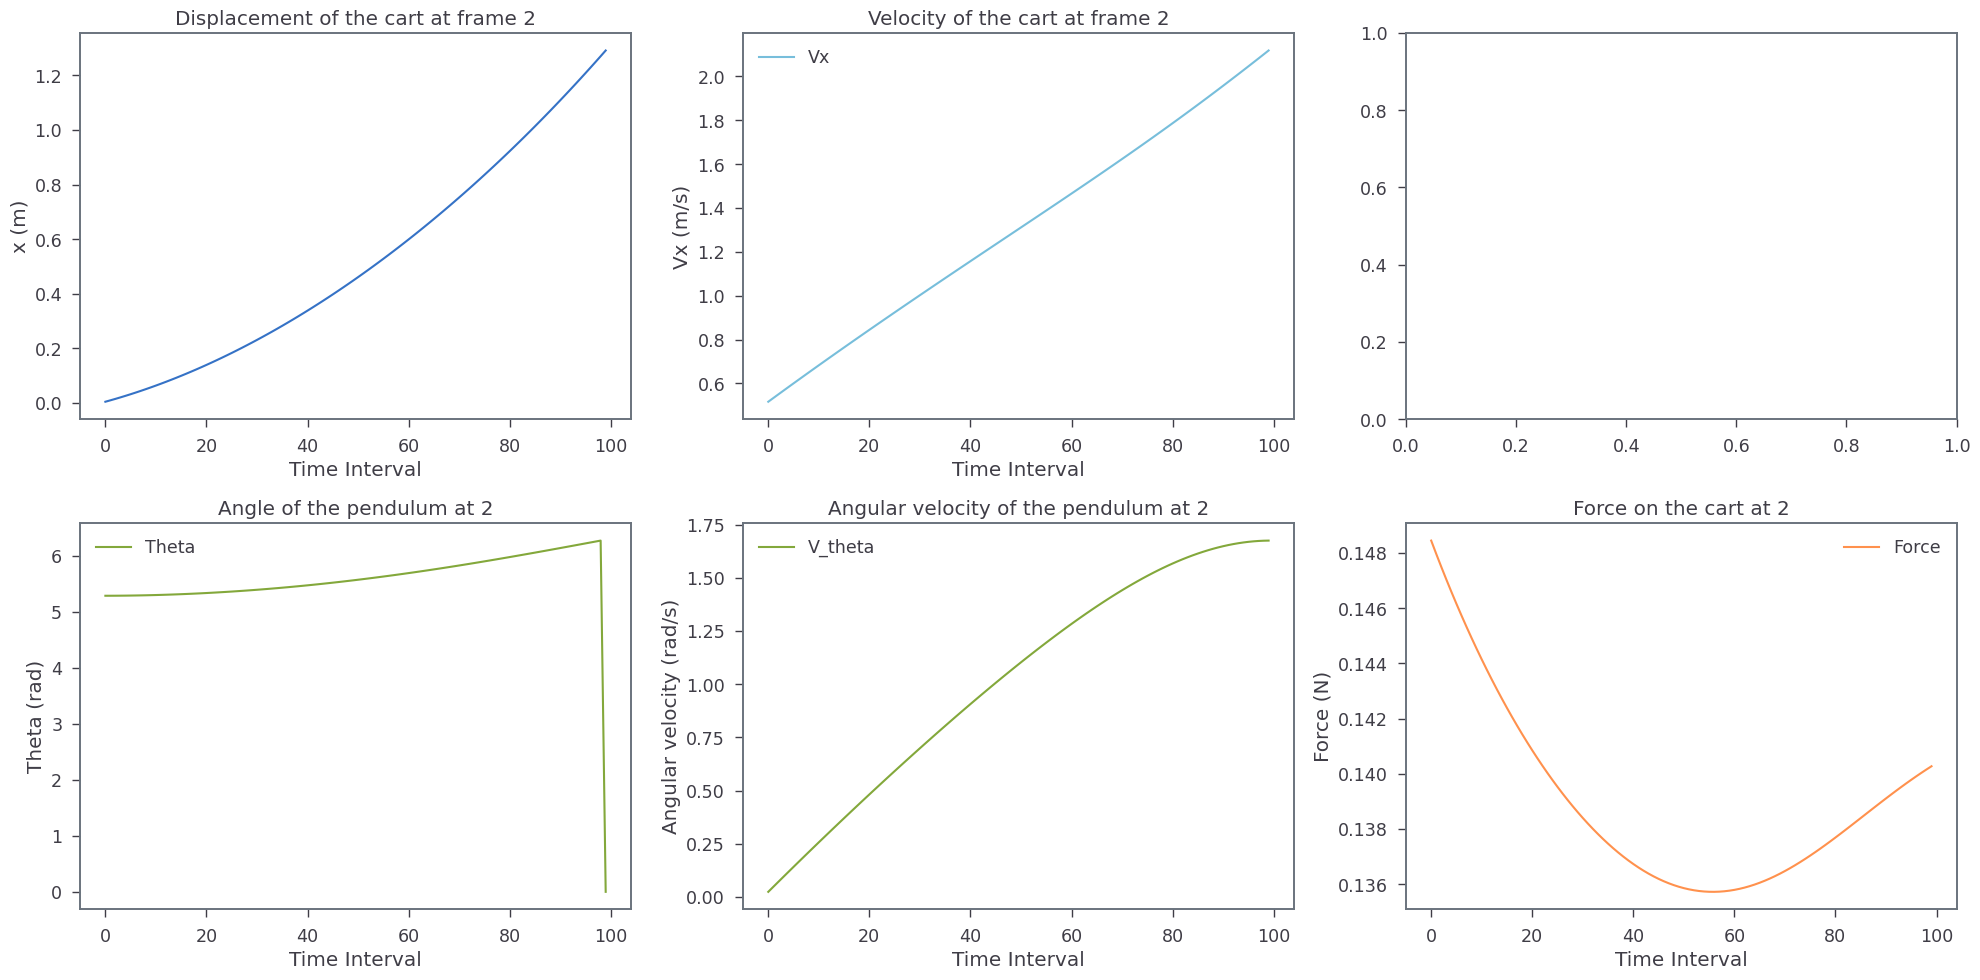

Angle: 302.7042305048303 5.2831855
Angle: 302.7178089209003 5.2834225
Angle: 302.7449384322836 5.283896
Angle: 302.7855643974668 5.284605
Angle: 302.8396321749367 5.2855487
Angle: 302.9071144439364 5.2867265
Angle: 302.98795656295266 5.2881374
Angle: 303.0821038904721 5.2897806
Angle: 303.1895564264948 5.291656
Angle: 303.31023220875056 5.293762
Angle: 303.4441039164828 5.2960987
Angle: 303.59111690817815 5.2986646
Angle: 303.7512165423233 5.301459
Angle: 303.9244028189181 5.3044815
Angle: 304.1105937756927 5.307731
Angle: 304.30973477113355 5.311207
Angle: 304.5218258052408 5.3149085
Angle: 304.746812236501 5.3188353
Angle: 304.9846121026442 5.3229856
Angle: 305.2351980829136 5.327359
Angle: 305.4985428565526 5.3319554
Angle: 305.7745917820478 5.3367734
Angle: 306.06329021788594 5.341812
Angle: 306.36461084331023 5.347071
Angle: 306.6784716960506 5.352549
Angle: 307.0048727761072 5.358246
Angle: 307.3437048004532 5.3641596
Angle: 307.6949950898453 5.3702908
Angle: 308.0586070405001 5.

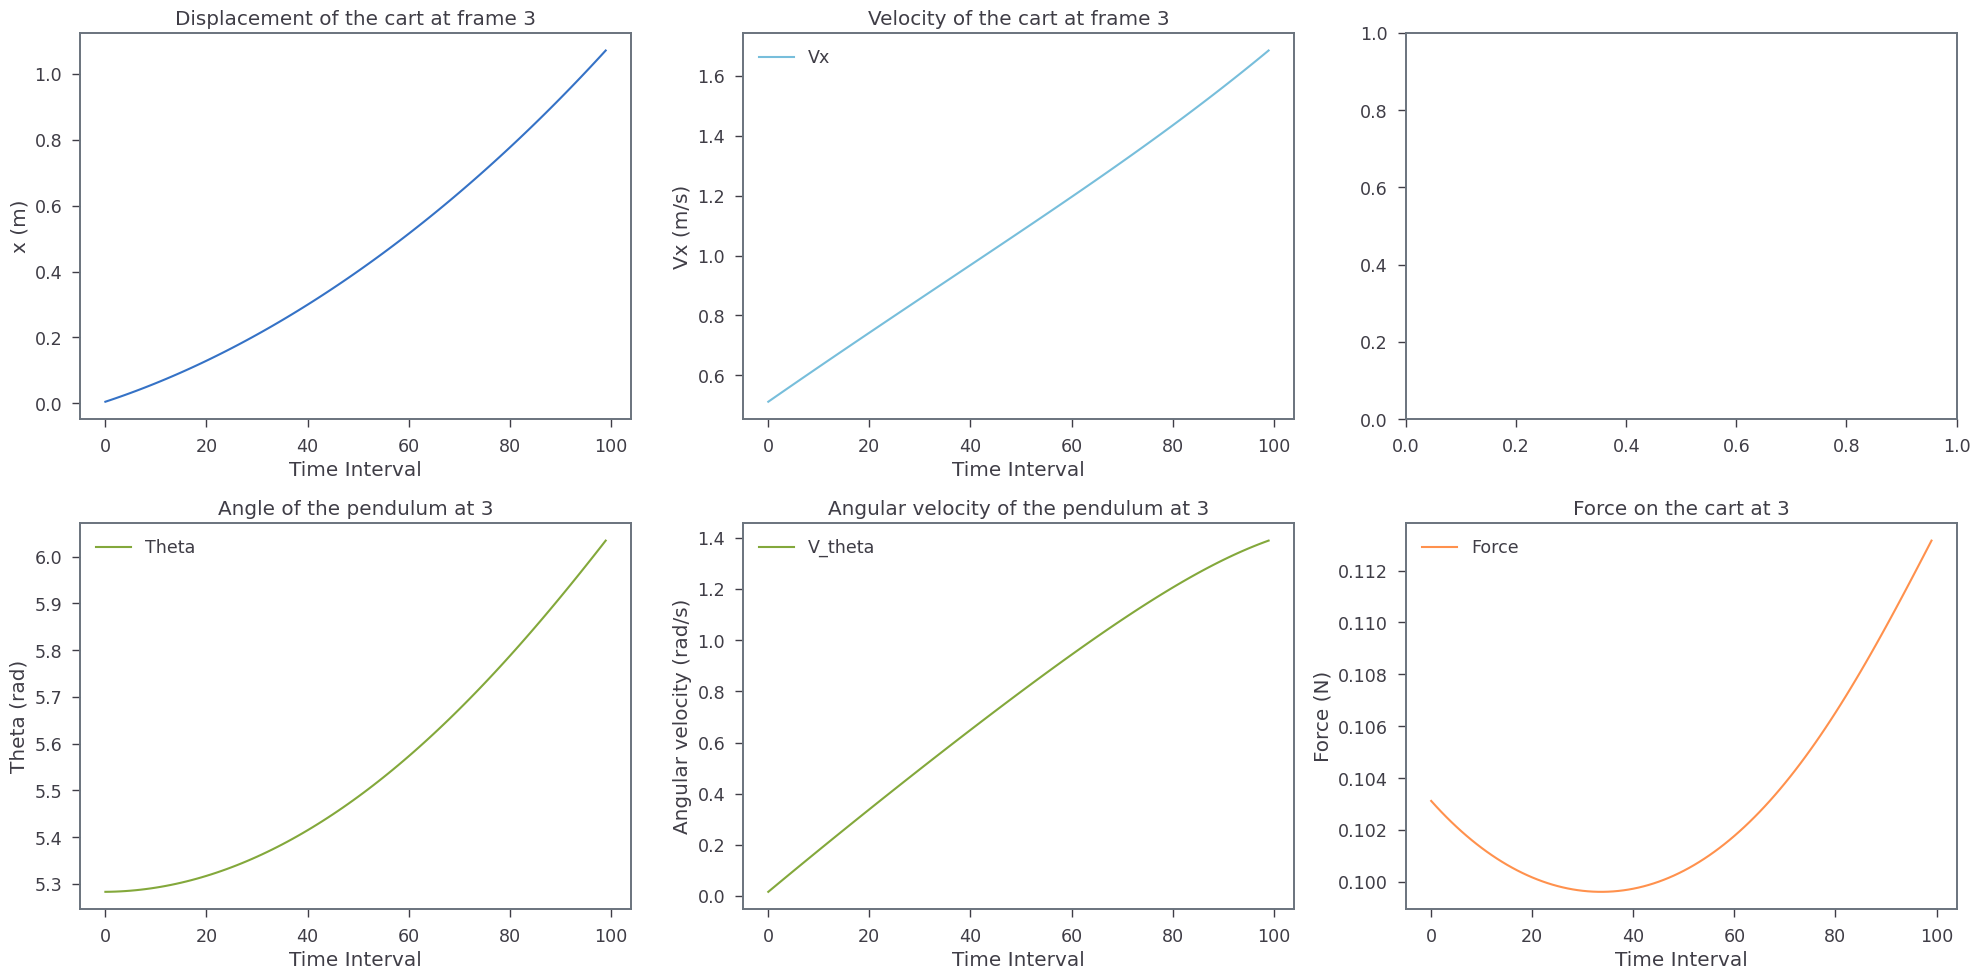

Angle: 302.7042305048303 5.2831855
Angle: 302.71365616588497 5.28335
Angle: 302.7325074879942 5.283679
Angle: 302.7607571504014 5.284172
Angle: 302.7984051531065 5.284829
Angle: 302.8453695338395 5.285649
Angle: 302.90170493411375 5.286632
Angle: 302.9673567124159 5.287778
Angle: 303.0422975479893 5.289086
Angle: 303.1265274408339 5.290556
Angle: 303.22004639094973 5.292188
Angle: 303.3227997568234 5.2939816
Angle: 303.4347875384549 5.295936
Angle: 303.5559824150876 5.2980514
Angle: 303.6863843867215 5.3003273
Angle: 303.8259388118432 5.302763
Angle: 303.9746730112094 5.305359
Angle: 304.1325596640634 5.3081145
Angle: 304.2995441288919 5.311029
Angle: 304.47565372645147 5.3141026
Angle: 304.66086113598556 5.317335
Angle: 304.8551390367374 5.320726
Angle: 305.05846010795034 5.3242745
Angle: 305.27085167038103 5.3279815
Angle: 305.4922317617595 5.3318453
Angle: 305.7226277028424 5.3358665
Angle: 305.96201217287296 5.3400445
Angle: 306.2103851718513 5.3443794
Angle: 306.46769205826405 5.3

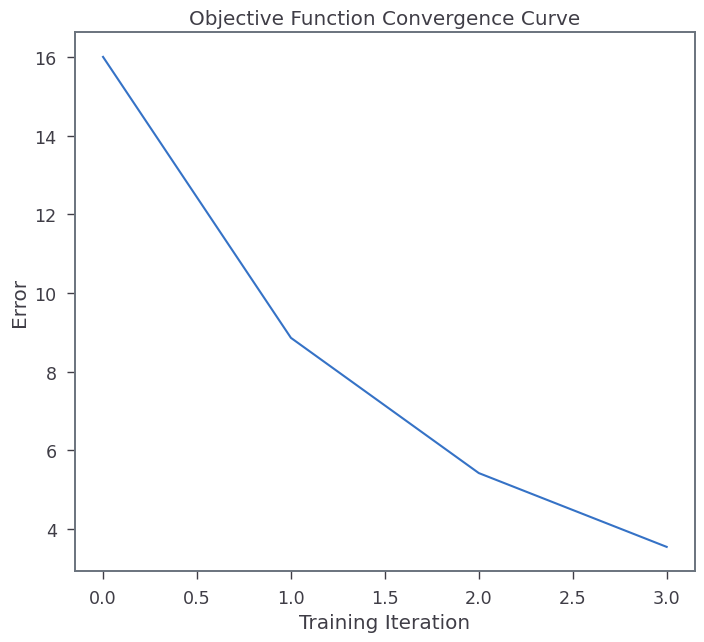

Generating Animation


IntProgress(value=0, max=101)

(100, 4) (100, 1)
/tmp/ipykernel_274/3899675743.py:142: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  pend_fig.set_data(pendulum_x, pendulum_y)
/tmp/ipykernel_274/3899675743.py:143: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  cart_fig.set_data(cart_x,0)
/tmp/ipykernel_274/3899675743.py:146: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  force_fig.set_data(cart_x+force_1 -0.5,0)


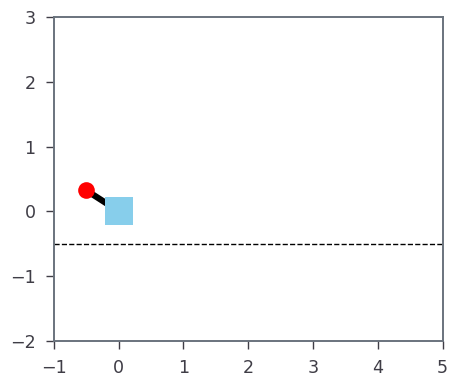

In [9]:
T = 100  # number of time steps of the simulation
dim_input = 4  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 1  # action space dimensions
d = Dynamics()  
c = Controller(dim_input, dim_hidden, dim_output)  
s = Simulation(c, d, T)  
o = Optimize(s)  
o.train(4)  # training with number of epochs (gradient descent steps)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e7c2bc5a-8560-49b0-9204-5d9e2bfeb73a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>